# CLIPTEXT Implementation - Emotion Dataset

This notebook implements the CLIPTEXT framework for zero-shot text classification using the emotion dataset.

In [1]:
# Cell 1: Imports and Setup
import torch
import clip
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from PIL import Image
import requests
from io import BytesIO
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Cell 2: Load and Process Dataset
def load_emotion_dataset():
    """Load the emotion dataset from Hugging Face"""
    # Clear cache first
    from datasets import load_dataset, disable_caching
    import shutil
    import os
    
    # Clear the entire cache directory
    cache_dir = os.path.expanduser("~/.cache/huggingface/datasets")
    if os.path.exists(cache_dir):
        shutil.rmtree(cache_dir)
    
    # Disable caching for this session
    disable_caching()
    
    # Load dataset with all verifications disabled
    dataset = load_dataset(
        'emotion',
        ignore_verifications=True,  # Ignore all verifications
        verification_mode="no_checks",  # Disable verification mode
        download_mode="force_redownload"  # Force fresh download
    )
    return dataset

# Load dataset
dataset = load_emotion_dataset()

# Define emotion labels
emotion_labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

# Print dataset info
print("Dataset splits:", dataset.keys())
print("Training examples:", len(dataset['train']))
print("Validation examples:", len(dataset['validation']))
print("Test examples:", len(dataset['test']))

# Print some examples
print("\nExample texts:")
for i in range(3):
    text = dataset['train'][i]['text']
    label = emotion_labels[dataset['train'][i]['label']]
    print(f"Text: {text}\nLabel: {label}\n")

/root/ENTER/envs/clip/lib/python3.7/site-packages/datasets/load.py:1763: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=no_checks' instead.
  FutureWarning,


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/split-dc935459dbea77dd/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Dataset splits: dict_keys(['train', 'validation', 'test'])
Training examples: 432809
Validation examples: 2000
Test examples: 2000

Example texts:
Text: i didnt feel humiliated
Label: sadness

Text: i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake
Label: sadness

Text: im grabbing a minute to post i feel greedy wrong
Label: anger



In [11]:
# Cell 3: CLIP Model Setup
def setup_clip_model():
    """Load and setup the CLIP model"""
    # 清理 GPU 缓存
    torch.cuda.empty_cache()
    
    # 设置 CUDA 设备
    torch.cuda.set_device(0)  # 使用第一个 GPU
    
    # 加载模型
    model, preprocess = clip.load("ViT-B/32", device=device)
    
    # 设置为评估模式以减少内存使用
    model.eval()
    
    # 禁用梯度计算
    for param in model.parameters():
        param.requires_grad = False
            
    return model, preprocess

# 设置较小的批处理大小以减少内存使用
BATCH_SIZE = 16  # 减小批处理大小

# 加载 CLIP 模型
print("正在加载 CLIP 模型...")
model, preprocess = setup_clip_model()
print(f"模型已加载到 {device} 设备")

正在加载 CLIP 模型...
模型已加载到 cpu 设备


In [12]:
# Cell 4: Label-Image Mapping
# Dictionary of image paths for each emotion label
emotion_images = {
    'sadness': 'emotion_images/sadness.jpg',
    'joy': 'emotion_images/joy.jpg',
    'love': 'emotion_images/love.jpg',
    'anger': 'emotion_images/anger.jpg',
    'fear': 'emotion_images/fear.jpg',
    'surprise': 'emotion_images/surprise.jpg'
}

def load_label_images(emotion_images, preprocess):
    """Load and preprocess images for each emotion label"""
    label_images = {}
    for emotion, path in emotion_images.items():
        img = Image.open(path)
        img_preprocessed = preprocess(img).unsqueeze(0).to(device)
        label_images[emotion] = img_preprocessed
    return label_images

In [13]:
# Cell 5: CLIPTEXT Implementation
class CLIPText:
    def __init__(self, model, preprocess, label_images):
        self.model = model
        self.preprocess = preprocess
        self.label_images = label_images
        
    @torch.no_grad()
    def predict(self, texts):
        """Predict the emotion label for given texts"""
        if isinstance(texts, str):
            texts = [texts]
            
        # Encode text
        text_tokens = clip.tokenize(texts).to(device)
        text_features = self.model.encode_text(text_tokens)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        
        # Get predictions
        predictions = []
        for text_feature in text_features:
            scores = {}
            for emotion, img in self.label_images.items():
                image_features = self.model.encode_image(img)
                image_features = image_features / image_features.norm(dim=-1, keepdim=True)
                # 确保数据类型匹配
                text_feature = text_feature.to(image_features.dtype)
                similarity = (100.0 * text_feature @ image_features.T).item()
                scores[emotion] = similarity
            predictions.append(max(scores.items(), key=lambda x: x[1])[0])
            
        return predictions[0] if len(predictions) == 1 else predictions

In [14]:
# Cell 6: Evaluation
def evaluate(model, dataset, batch_size=32):
    """Evaluate model performance"""
    predictions = []
    true_labels = []
    
    for i in range(0, len(dataset), batch_size):
        batch = dataset[i:i+batch_size]
        texts = batch['text']
        labels = [emotion_labels[label] for label in batch['label']]
        
        batch_preds = model.predict(texts)
        predictions.extend(batch_preds)
        true_labels.extend(labels)
    
    # Calculate metrics
    correct = sum(p == l for p, l in zip(predictions, true_labels))
    accuracy = correct / len(true_labels) * 100
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(true_labels, predictions))
    
    return accuracy, predictions, true_labels

def plot_confusion_matrix(true_labels, predictions):
    """Plot confusion matrix"""
    cm = confusion_matrix(true_labels, predictions, labels=emotion_labels)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=emotion_labels,
                yticklabels=emotion_labels)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

Emotion Label Images (Used for classification):


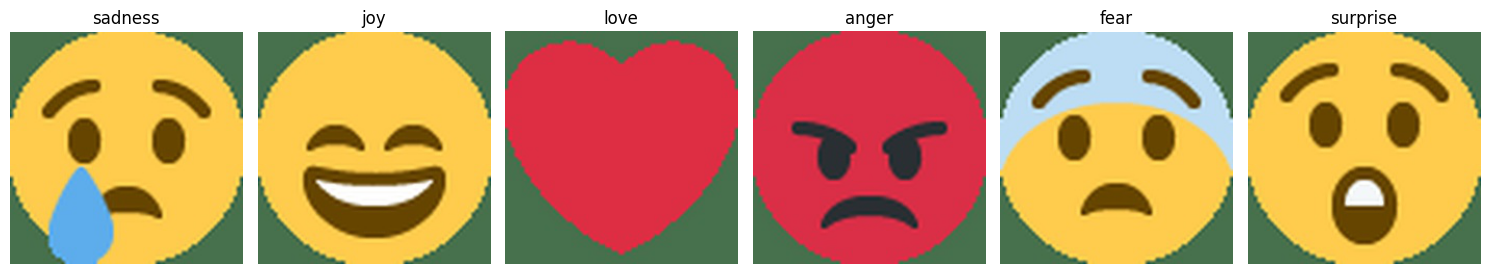


Selected 30 test samples (6 emotions × 5 samples each)

Testing CLIPTEXT Process:

Input text: i am feeling grouchy
True emotion: anger

Similarity scores with each emotion:
----------------------------------------
anger     :    25.77
sadness   :    23.53
fear      :    22.89
surprise  :    22.14
joy       :    20.75
love      :    20.12

Predicted emotion: anger
Prediction ✓ 

Input text: i feel as confused about life as a teenager or as jaded as a year old man
True emotion: fear

Similarity scores with each emotion:
----------------------------------------
sadness   :    22.65
anger     :    22.40
fear      :    20.84
surprise  :    20.30
joy       :    20.00
love      :    18.88

Predicted emotion: sadness
Prediction ✗ (should be fear)

Input text: i too feel as if i am a stranger in a strange land and i am raising my son in a place that is not his father s ancestral home
True emotion: surprise

Similarity scores with each emotion:
----------------------------------------
sadness 

/root/ENTER/envs/clip/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/ENTER/envs/clip/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/ENTER/envs/clip/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


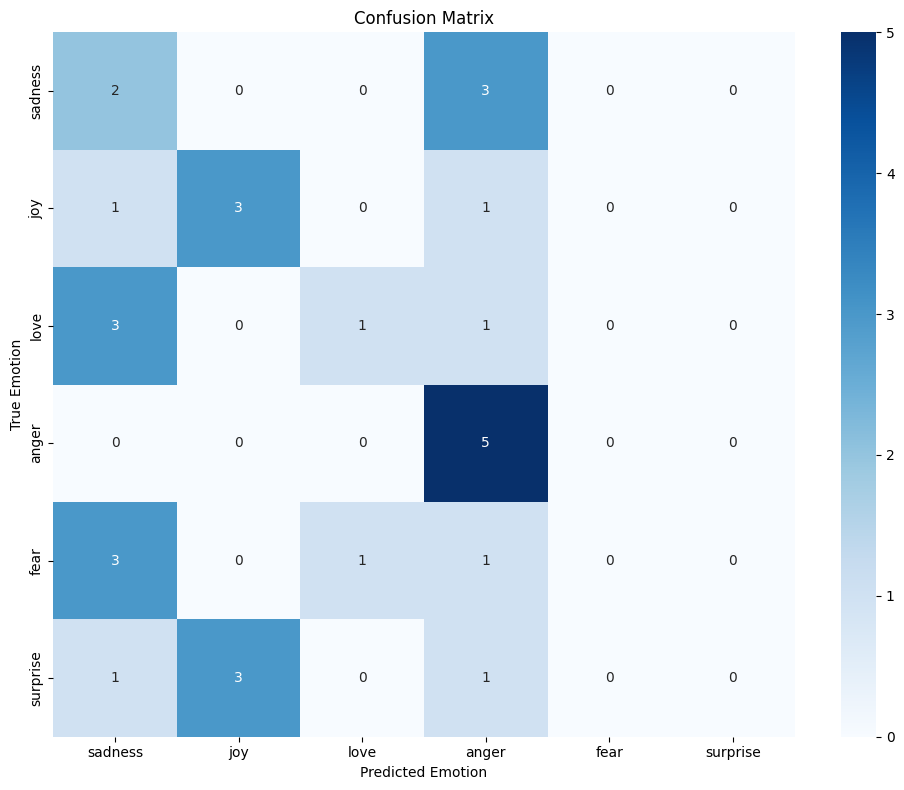

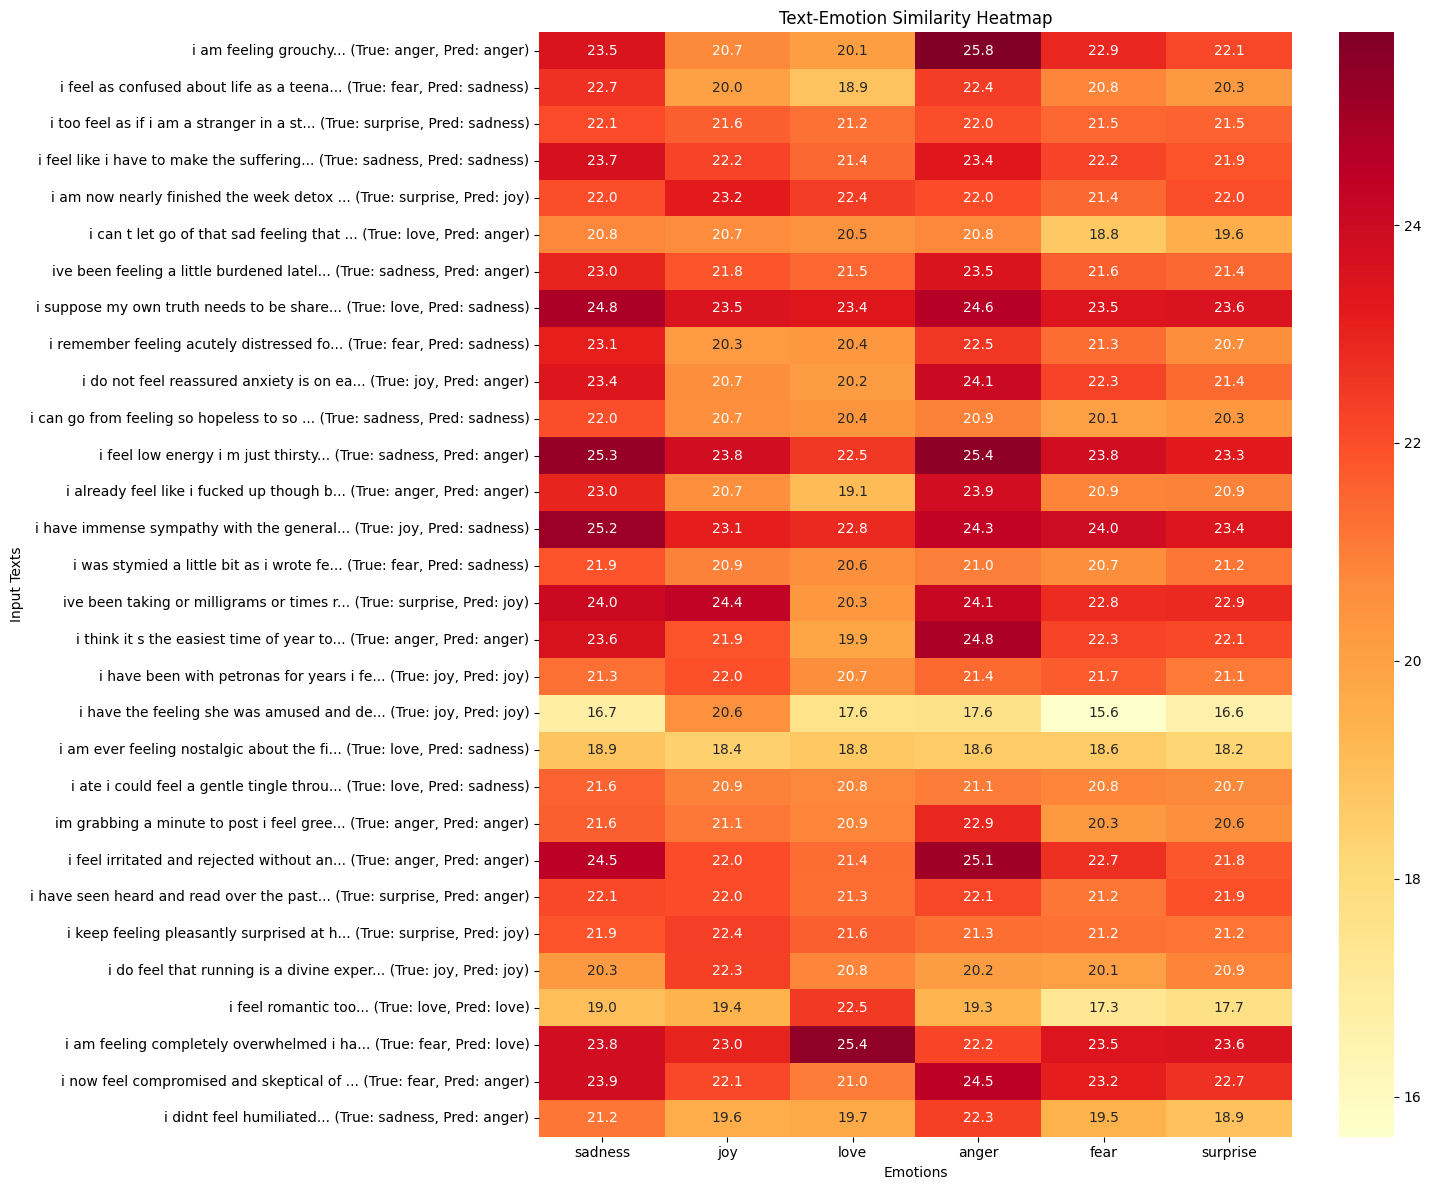


Performance by Emotion:
----------------------------------------
sadness   : 2/5 correct (40.0%)
joy       : 3/5 correct (60.0%)
love      : 1/5 correct (20.0%)
anger     : 5/5 correct (100.0%)
fear      : 0/5 correct (0.0%)
surprise  : 0/5 correct (0.0%)


In [19]:
# Cell 7: Test Cases and Visualization with Accuracy Evaluation
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import random
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

def get_balanced_test_samples(dataset, n_samples_per_emotion=5):
    """从训练集中均衡采样测试样本，同时保留真实标签
    Args:
        dataset: 包含训练数据的数据集
        n_samples_per_emotion: 每种情感要采样的样本数量
    Returns:
        list: (文本, 真实标签) 元组的列表
    """
    samples_by_emotion = {label: [] for label in emotion_labels}
    
    # 遍历训练集，按情感类别收集样本
    for item in dataset['train']:
        emotion = emotion_labels[item['label']]
        text = item['text']
        if len(samples_by_emotion[emotion]) < n_samples_per_emotion:
            # 保存文本和真实标签
            samples_by_emotion[emotion].append((text, emotion))
    
    # 合并所有样本
    test_samples = []
    for emotion in emotion_labels:
        test_samples.extend(samples_by_emotion[emotion])
    
    # 随机打乱顺序
    random.shuffle(test_samples)
    return test_samples

def test_single_prediction_with_process(model, text, true_label=None):
    """测试单个文本的预测过程，并与真实标签比较
    Args:
        model: CLIPTEXT 模型实例
        text: 输入文本
        true_label: 真实情感标签
    """
    print(f"\n{'='*50}")
    print(f"Input text: {text}")
    if true_label:
        print(f"True emotion: {true_label}")
    print(f"{'='*50}")
    
    # 文本编码
    text_tokens = clip.tokenize([text]).to(device)
    with torch.no_grad():
        text_features = model.model.encode_text(text_tokens)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
    
    # 计算相似度
    similarities = {}
    for emotion, img in model.label_images.items():
        with torch.no_grad():
            image_features = model.model.encode_image(img)
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            similarity = (100.0 * text_features @ image_features.T).item()
            similarities[emotion] = similarity
    
    # 按相似度排序
    sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)
    
    print("\nSimilarity scores with each emotion:")
    print("-" * 40)
    for emotion, score in sorted_similarities:
        print(f"{emotion:10s}: {score:8.2f}")
    
    prediction = sorted_similarities[0][0]
    print("\nPredicted emotion:", prediction)
    
    if true_label:
        is_correct = prediction == true_label
        print(f"Prediction {'✓' if is_correct else '✗'} {'' if is_correct else f'(should be {true_label})'}")
    
    return prediction, similarities

# 主执行流程
# 1. 显示情感图片
print("Emotion Label Images (Used for classification):")
display_emotion_images(emotion_images)

# 2. 获取带标签的测试样本
test_samples = get_balanced_test_samples(dataset, n_samples_per_emotion=5)
print(f"\nSelected {len(test_samples)} test samples ({len(emotion_labels)} emotions × 5 samples each)")

# 3. 创建模型实例
label_images = load_label_images(emotion_images, preprocess)
cliptext_model = CLIPText(model, preprocess, label_images)

# 4. 进行预测并收集结果
print("\nTesting CLIPTEXT Process:")
results = []
true_labels = []
pred_labels = []

for text, true_label in test_samples:
    pred, sims = test_single_prediction_with_process(cliptext_model, text, true_label)
    results.append((text, true_label, pred, sims))
    true_labels.append(true_label)
    pred_labels.append(pred)

# 5. 计算并显示整体性能指标
print("\n" + "="*50)
print("Overall Performance Metrics:")
print("="*50)

# 计算准确率
accuracy = accuracy_score(true_labels, pred_labels)
print(f"\nOverall Accuracy: {accuracy*100:.2f}%")

# 显示详细的分类报告
print("\nDetailed Classification Report:")
print(classification_report(true_labels, pred_labels))

# 6. 绘制混淆矩阵
plt.figure(figsize=(10, 8))
plt.title("Confusion Matrix")
cm = confusion_matrix(true_labels, pred_labels, labels=emotion_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=emotion_labels,
            yticklabels=emotion_labels)
plt.xlabel('Predicted Emotion')
plt.ylabel('True Emotion')
plt.tight_layout()
plt.show()

# 7. 绘制相似度热力图
plt.figure(figsize=(15, len(test_samples)*0.4))
plt.title("Text-Emotion Similarity Heatmap")

similarity_matrix = np.zeros((len(test_samples), len(emotion_labels)))
for i, (text, true_label, pred, sims) in enumerate(results):
    for j, emotion in enumerate(emotion_labels):
        similarity_matrix[i, j] = sims[emotion]

# 创建带有真实标签和预测的标签
text_labels = [f"{text[:40]}... (True: {true}, Pred: {pred})" 
               for text, true, pred, _ in results]

sns.heatmap(similarity_matrix,
            xticklabels=emotion_labels,
            yticklabels=text_labels,
            annot=True, fmt='.1f', cmap='YlOrRd')
plt.xlabel("Emotions")
plt.ylabel("Input Texts")
plt.tight_layout()
plt.show()

# 8. 按情感类别统计性能
print("\nPerformance by Emotion:")
print("-" * 40)
for emotion in emotion_labels:
    # 找出该情感的所有样本
    emotion_samples = [(true == emotion, pred == emotion) 
                      for _, true, pred, _ in results 
                      if true == emotion]
    
    correct = sum(1 for true, pred in emotion_samples if true and pred)
    total = len(emotion_samples)
    accuracy = (correct / total * 100) if total > 0 else 0
    
    print(f"{emotion:10s}: {correct}/{total} correct ({accuracy:.1f}%)")